In [2]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu121'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
import requests
import zipfile
from pathlib import Path

#setup path to data directory
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

#if image folder DNE, download it
if image_path.is_dir():
  print(f"dir exists")
else:
  print(f'did not find directory, creating one')
  image_path.mkdir(parents = True, exist_ok = True)

  #download data
  with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading data')
    f.write(request.content)

  #unzip data
  with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('unzipping data')
    zip_ref.extractall(image_path)

did not find directory, creating one
unzipping data


In [5]:
import os
def walk_through_dir(dir_path):
  #walk through path, return contents (num of sub directories, num files in each, name of each)
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")


In [6]:
walk_through_dir(image_path)

there are 2 directories and 0 images in 'data/pizza_steak_sushi'
there are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
there are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
there are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
there are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
there are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
there are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
there are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
there are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'


In [7]:
#train and test paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

rand img path: data/pizza_steak_sushi/train/pizza/3441394.jpg
image_class: pizza
img height, width: 512, 512


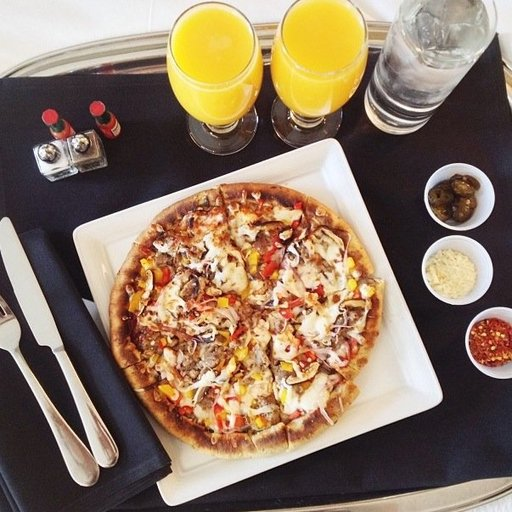

In [8]:
import random
from PIL import Image

random.seed(42)

#get image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

#random img path
random_image_path = random.choice(image_path_list)

#get img class (from directory name)
image_class = random_image_path.parent.stem

#open img
img = Image.open(random_image_path)

#metadata
print(f'rand img path: {random_image_path}')
print(f'image_class: {image_class}')
print(f'img height, width: {img.height}, {img.width}')
img


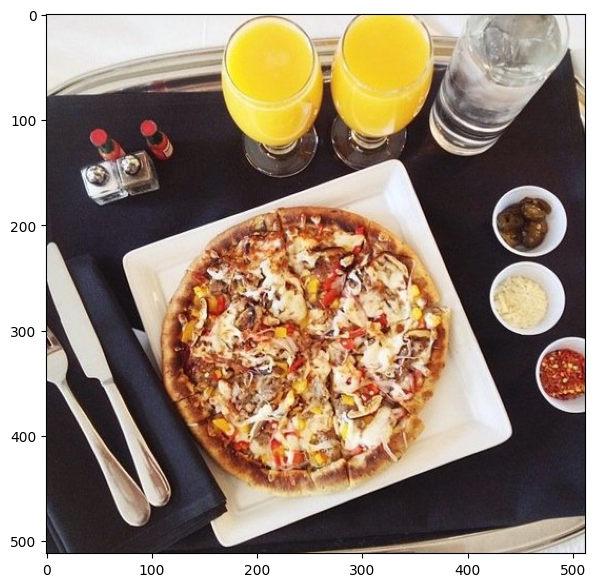

In [9]:
#view with pyplot
import numpy as np
import matplotlib.pyplot as plt

#img to arr
img_as_arr = np.asarray(img)

plt.figure(figsize = (10, 7))
plt.imshow(img_as_arr)

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
#tranform
data_trans = transforms.Compose([
    #resize
    transforms.Resize(size = (64, 64)),
    #flip img randomly on horizontal
    transforms.RandomHorizontalFlip(p = 0.5),
    #turn into tensor
    transforms.ToTensor() #also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

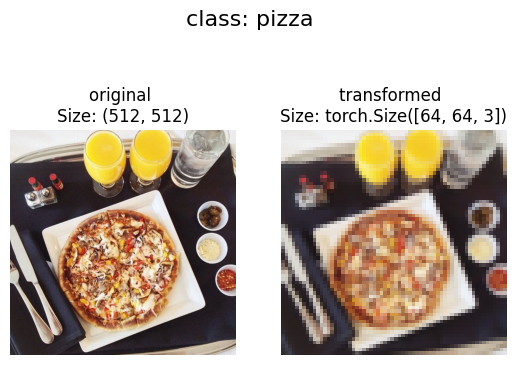

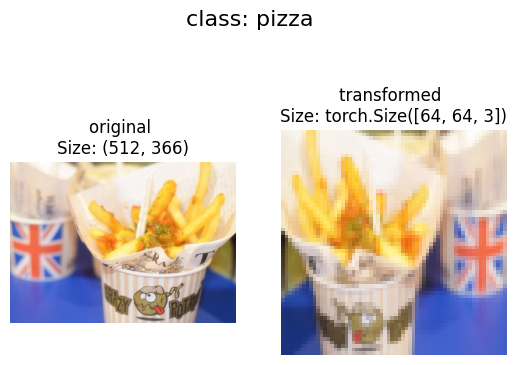

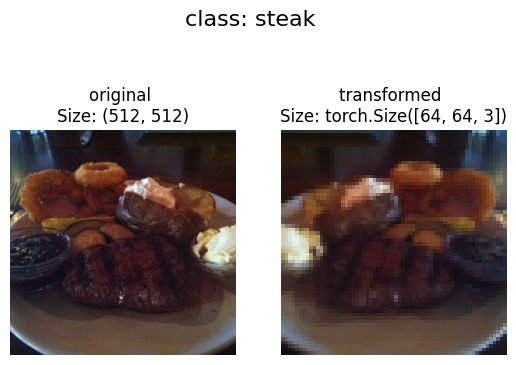

In [12]:
#try out transform
def plot_transformed_images(image_paths, transform, n = 3, seed = 42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f'original \nSize: {f.size}')
      ax[0].axis('off')

      #transform and plot
      # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C]) so must permute
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'transformed \nSize: {transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f'class: {image_path.parent.stem}', fontsize =16)

plot_transformed_images(image_path_list,
                        transform = data_trans,
                        n = 3)

In [13]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_trans,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_trans)

print(f"train data: \n{train_data}\n test data: \n{test_data}")

train data: 
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
 test data: 
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [14]:
from torch.utils.data import DataLoader
train_dl = DataLoader(dataset = train_data,
                      batch_size = 1,
                      num_workers =1, #num subprocesse to use for data loading
                      shuffle = True)

test_dl = DataLoader(dataset = test_data,
                     batch_size = 1,
                     num_workers = 1,
                     shuffle = False)

train_dl, test_dl

(<torch.utils.data.dataloader.DataLoader at 0x7ed85b57a6b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ed85b5aff70>)

In [15]:
img, label = next(iter(train_dl))

img.shape, label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

In [16]:
#trivial augmentations artificially increase the training dataset by altering data
train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                       transforms.ToTensor()
                                       ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

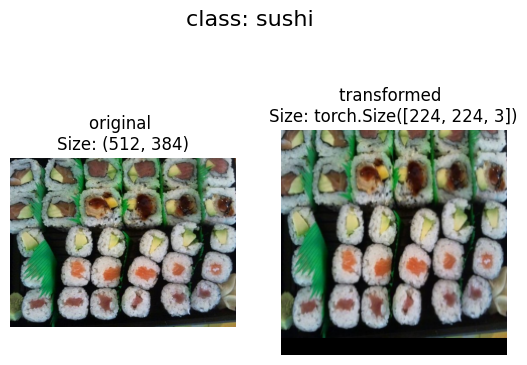

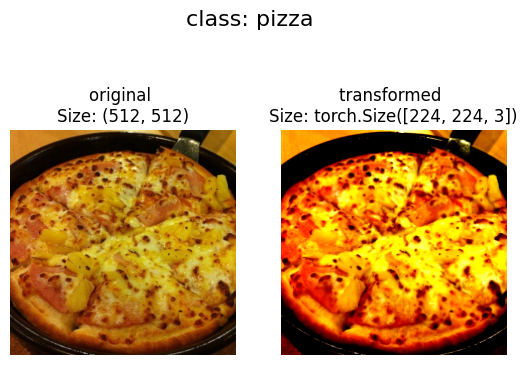

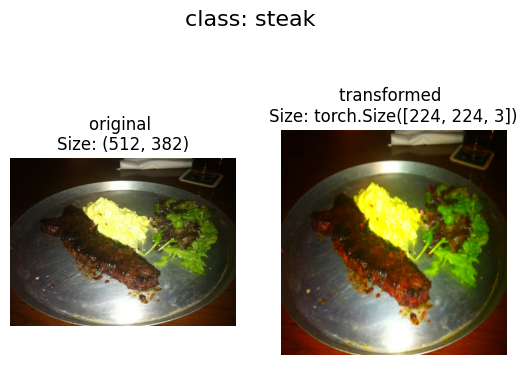

In [17]:
image_path_list = list(image_path.glob('*/*/*.jpg'))

plot_transformed_images(image_paths=image_path_list,
                        transform = train_transforms,
                        n = 3,
                        seed = None)

In [18]:
simple_trans = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [19]:
#load and transform data
train_data_simple = datasets.ImageFolder(root = train_dir, transform = simple_trans)
test_data_simple = datasets.ImageFolder(root = test_dir, transform = simple_trans)

#turn into DL
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"batch size: {BATCH_SIZE} workers: {NUM_WORKERS}")

train_DL_simple = DataLoader(train_data_simple,
                            batch_size = BATCH_SIZE,
                            shuffle = True,
                            num_workers = NUM_WORKERS)
test_DL_simple = DataLoader(test_data_simple,
                            batch_size = BATCH_SIZE,
                            shuffle = False,
                            num_workers = NUM_WORKERS)

train_DL_simple, test_DL_simple

batch size: 32 workers: 2


(<torch.utils.data.dataloader.DataLoader at 0x7ed85b3e7040>,
 <torch.utils.data.dataloader.DataLoader at 0x7ed85b381870>)

In [20]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) ->None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features = output_shape)
    )

  def forward(self, x: torch.Tensor):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [21]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3, #3 color channels for RGB
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [22]:
#batch of img and labels
img_batch, label_batch = next(iter(train_DL_simple))

#get single img and unsqueeze
img_single, label_single = img_batch[0].unsqueeze(dim = 0), label_batch[0]
print(img_single.shape)

#forward pass
model_0.eval()
with torch.inference_mode():
  pred = model_0(img_single.to(device))

print(f'logits: {pred}')
print(f'pred probs: {torch.softmax(pred, dim = 1)}\n')
print(f'pred label: {torch.argmax(torch.softmax(pred, dim = 1), dim =1)}\n')
print(f'actual label: {label_single}')

torch.Size([1, 3, 64, 64])
logits: tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')
pred probs: tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

pred label: tensor([1], device='cuda:0')

actual label: 2


In [23]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

In [24]:
summary(model_0, input_size = [1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [25]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train() #train mode
  train_loss, train_acc = 0,0
  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [26]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer):
  model.eval()
  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim = 1)
      test_acc +=((test_pred_labels== y).sum().item()/len(test_pred_labels))

  test_loss /= len(dataloader)
  test_acc/=len(dataloader)
  return test_loss, test_acc

In [27]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_DL: torch.utils.data.DataLoader,
          test_DL: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  results = {'train_loss': [],
             'train_acc': [],
             'test_loss': [],
             'test_acc': []}
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model, dataloader = train_DL,
                                       loss_fn = loss_fn, optimizer = optimizer)
    test_loss, test_acc = test_step(model = model, dataloader = test_DL,
                                    loss_fn = loss_fn, optimizer=optimizer)

    print(
        f'epoch: {epoch+1} | '
        f'train_loss: {train_loss:.4f} | '
        f'train_acc: {train_acc:.2f} | '
        f'test_loss: {test_loss:.4f} | '
        f'test_acc: {test_acc:.2f}'
    )

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  return results

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 5

model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model = model_0,
                        train_DL = train_DL_simple,
                        test_DL = test_DL_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = EPOCHS)

end_time = timer()
print(f'total train time: {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 | train_loss: 1.1078 | train_acc: 0.26 | test_loss: 1.1362 | test_acc: 0.26
epoch: 2 | train_loss: 1.0846 | train_acc: 0.43 | test_loss: 1.1622 | test_acc: 0.20
epoch: 3 | train_loss: 1.1153 | train_acc: 0.29 | test_loss: 1.1695 | test_acc: 0.20
epoch: 4 | train_loss: 1.0990 | train_acc: 0.29 | test_loss: 1.1342 | test_acc: 0.20
epoch: 5 | train_loss: 1.0989 | train_acc: 0.29 | test_loss: 1.1434 | test_acc: 0.20
total train time: 11.760 seconds


In [29]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [30]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results['train_loss']
  test_loss = results['test_loss']

  acc = results['train_acc']
  test_acc = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize = (15, 7))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label = 'train_loss')
  plt.plot(epochs, test_loss, label = 'test_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  #plot acc
  plt.subplot(1,2,2)
  plt.plot(epochs, acc, label = 'train_acc')
  plt.plot(epochs, test_acc, label = 'test_acc')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend();

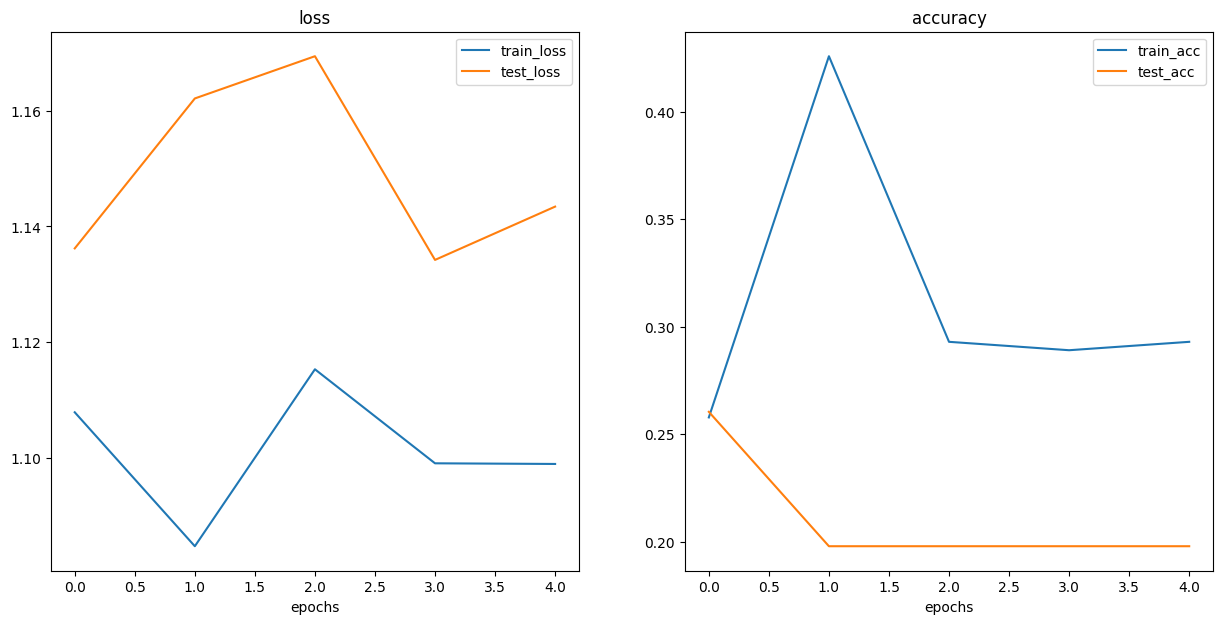

In [31]:
plot_loss_curves(model_0_results)

In [35]:
from torchvision import transforms
#add transforms with trivial augment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [36]:
train_data_augmented = datasets.ImageFolder(train_dir, transform = train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform = test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [39]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        num_workers = NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

train_dataloader_augmented, tets_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7ed7eabfabf0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ed7eac5e2c0>)

In [40]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape = 3, hidden_units= 10,
                  output_shape = len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [43]:
#use train setup from before
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.001)

start_time = timer()
model_1_results = train(model_1,
                        train_DL = train_dataloader_augmented,
                        test_DL = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)
end_time = timer()
print(f'total train time: {end_time - start_time:.3f} s')

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 | train_loss: 1.1076 | train_acc: 0.25 | test_loss: 1.1062 | test_acc: 0.26
epoch: 2 | train_loss: 1.0791 | train_acc: 0.43 | test_loss: 1.1388 | test_acc: 0.26
epoch: 3 | train_loss: 1.0810 | train_acc: 0.43 | test_loss: 1.1696 | test_acc: 0.26
epoch: 4 | train_loss: 1.1293 | train_acc: 0.30 | test_loss: 1.1625 | test_acc: 0.26
epoch: 5 | train_loss: 1.0900 | train_acc: 0.43 | test_loss: 1.1483 | test_acc: 0.26
total train time: 7.558 s


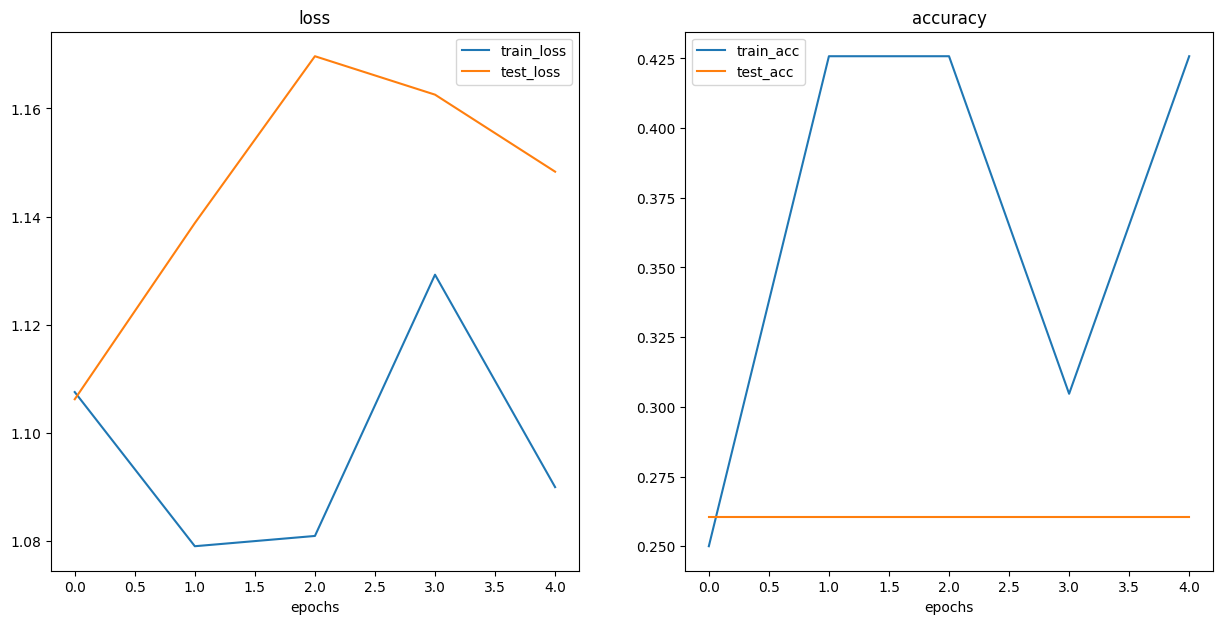

In [44]:
plot_loss_curves(model_1_results)

In [45]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107836,0.257812,1.136208,0.260417
1,1.084645,0.425781,1.162168,0.197917
2,1.115279,0.292969,1.169480,0.197917
3,1.099000,0.289062,1.134215,0.197917
4,1.098888,0.292969,1.143442,0.197917


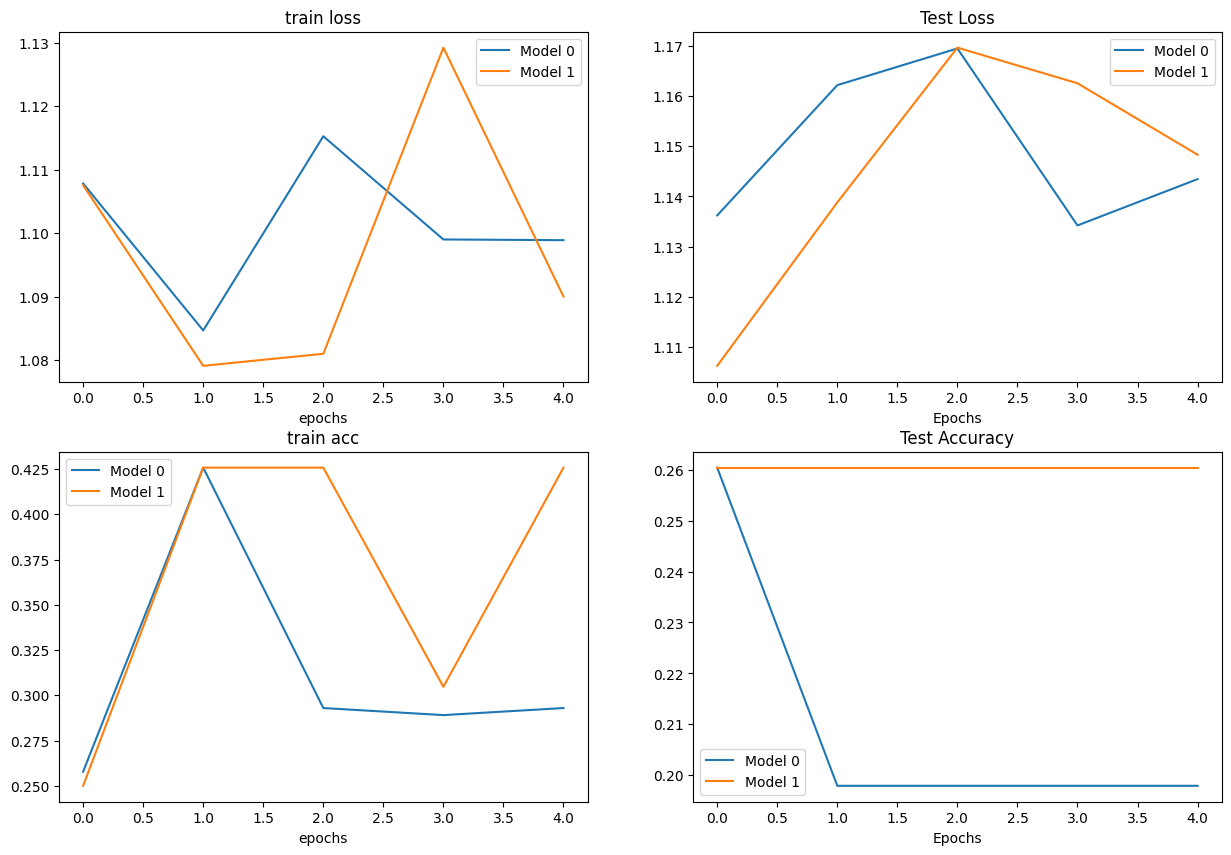

In [46]:
plt.figure(figsize = (15, 10))

epochs = range(len(model_0_df))

#plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label = 'Model 0')
plt.plot(epochs, model_1_df['train_loss'], label = 'Model 1')
plt.title('train loss')
plt.xlabel('epochs')
plt.legend()

#plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

#plot train acc
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df['train_acc'], label = 'Model 0')
plt.plot(epochs, model_1_df['train_acc'], label = 'Model 1')
plt.title('train acc')
plt.xlabel('epochs')
plt.legend()

#plot test acc
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df['test_acc'], label = 'Model 0')
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

In [47]:
#try prediction on a new image
custom_image_path = data_path/ '04-pizza-dad.jpeg'

if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f'downloading')
    f.write(request.content)
else:
  print(f"already exists")

downloading


In [49]:
import torchvision
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f'custom img tensor: \n{custom_image_uint8}\n')
print(f'custom img shape: {custom_image_uint8.shape}')
print(f'custom img dtype: {custom_image_uint8.dtype}')

custom img tensor: 
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

custom img shape: torch.Size([3, 4032, 3024])
custom img dtype: to

In [50]:
#must convert new image to the same format as training data (tensors of dtype torch.flaot32)
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

#divide pixel vals by 255 to get them between 0 and 1
custom_image = custom_image / 255


print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

In [51]:
#wrong shape [3, 4032, 3024] we need [3, 64, 64]
#create transform pipeline to resize
custom_image_transform = transforms.Compose([
    transforms.Resize((64,64))
])

custom_image_transformed = custom_image_transform(custom_image)


print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [52]:
model_1.eval()
with torch.inference_mode():
  custom_img_pred = model_1(custom_image_transformed.to(device))

RuntimeError: ignored

In [55]:
#forgot batch size
model_1.eval()
with torch.inference_mode():
  custom_img_trans_with_batch = custom_image_transformed.unsqueeze(dim = 0)


  print(f"Custom image transformed shape: {custom_image_transformed.shape}")
  print(f"Unsqueezed custom image shape: {custom_img_trans_with_batch.shape}")

  custom_img_pred = model_1(custom_img_trans_with_batch.to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [56]:
custom_img_pred

tensor([[ 0.1160,  0.0334, -0.1422]], device='cuda:0')

In [57]:
#pred probs
custom_img_pred_probs = torch.softmax(custom_img_pred, dim = 1)
print(f' pred probs: {custom_img_pred_probs}')

#pred label
custom_img_pred_label = torch.argmax(custom_img_pred_probs, dim = 1)
print(f'pred label: {custom_img_pred_label}')

 pred probs: tensor([[0.3713, 0.3419, 0.2868]], device='cuda:0')
pred label: tensor([0], device='cuda:0')


In [59]:
class_names = train_data.classes

In [60]:
custom_img_pred_class = class_names[custom_img_pred_label.cpu()]
custom_img_pred_class

'pizza'

In [61]:
custom_img_pred_probs

tensor([[0.3713, 0.3419, 0.2868]], device='cuda:0')

In [64]:
#function for prediting new data
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device: torch.device = device):
  #load img and convert to float32
  target = torchvision.io.read_image(str(image_path)).type(torch.float32)

  #rescale pixel vals
  target = target / 255

  #transform if needed
  if transform:
    target = transform(target)

  #put on right device
  model.to(device)

  #eval mode
  model.eval()
  with torch.inference_mode():
    #extra dim for batch
    target = target.unsqueeze(dim = 0)

    target_pred = model(target.to(device))

  #logit to pred prob
  target_pred_probs = torch.softmax(target_pred, dim = 1)

  #pred probs to labels
  target_pred_label = torch.argmax(target_pred_probs, dim = 1)

  #plot image alongside prediction and pred prob
  plt.imshow(target.squeeze().permute(1,2,0))
  if class_names:
    title = f'pred: {class_names[target_pred_label.cpu()]} | prob: {target_pred_probs.max().cpu():.3f}'
  else:
    title = f'pred: {target_pred_label} | prob { target_pred_probs.max().cpu():.3f}'
  plt.title(title)
  plt.axis(False);

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


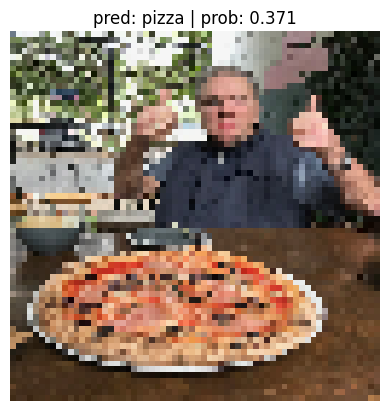

In [65]:
pred_and_plot_image(model = model_1,
                    image_path = custom_image_path,
                    class_names = class_names,
                    transform = custom_image_transform,
                    device = device)